# Challenge Set 1

Topic:        Challenge Set 1
Subject:      Explore MTA turnstile data
Date:         09/30/2018
Name:         Matthew Ahlborg
Worked with:  Druce Vertes, Goodwin Chen, William Hill



In [31]:
import pandas as pd
import numpy as np

### Challenge 1
Open up a new IPython notebook
Download a few MTA turnstile data files
Read them into a pandas dataframe (pd.read_csv()), format the columns nicely, and display the first few rows.

In [32]:
mta180915 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_180915.txt")
mta180922 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_180922.txt")
df = pd.concat([mta180915,mta180922])

In [33]:
df.columns = [column.strip() for column in df.columns]

In [34]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/08/2018,00:00:00,REGULAR,6751094,2288561
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/08/2018,04:00:00,REGULAR,6751114,2288564
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/08/2018,08:00:00,REGULAR,6751132,2288599
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/08/2018,12:00:00,REGULAR,6751205,2288673
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/08/2018,16:00:00,REGULAR,6751442,2288720


### Challenge 2
Let's turn this into a time series.
Create a new column that stores the date and time as a single pandas datetime object.

In [35]:
df['DATETIME'] = pd.to_datetime(df['DATE'] + " " + df['TIME'])

### Challenge 3
These counts are for every n hours (What is n?). Also, there's something odd about these "counts", what is it? Do they actually represent total entries for a time period, or something else? We want total daily entries, create a new dataframe with one row per turnstile/day and a column that gives total daily entries.

In [36]:
turnstiles_daily = (df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())

In [37]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,09/08/2018,6751094
1,A002,R051,02-00-00,59 ST,09/09/2018,6751792
2,A002,R051,02-00-00,59 ST,09/10/2018,6752254
3,A002,R051,02-00-00,59 ST,09/11/2018,6753421
4,A002,R051,02-00-00,59 ST,09/12/2018,6754783


In [38]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .transform(lambda grp: grp.shift(1)))

In [39]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,09/08/2018,6751094,NaN,NaN
1,A002,R051,02-00-00,59 ST,09/09/2018,6751792,09/08/2018,6751094.0
2,A002,R051,02-00-00,59 ST,09/10/2018,6752254,09/09/2018,6751792.0
3,A002,R051,02-00-00,59 ST,09/11/2018,6753421,09/10/2018,6752254.0
4,A002,R051,02-00-00,59 ST,09/12/2018,6754783,09/11/2018,6753421.0


In [40]:
# Drop the rows for the earliest date in the df
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [41]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

1525 15832652.0
525054 3346426.0
6 8203336.0
85 1632278.0
685 1512945.0
1131407 8912.0
11154 1144357.0
32375149 157468.0
78 3308167.0
440 3159530.0


In [42]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,09/09/2018,6751792,09/08/2018,6751094.0,698.0
2,A002,R051,02-00-00,59 ST,09/10/2018,6752254,09/09/2018,6751792.0,462.0
3,A002,R051,02-00-00,59 ST,09/11/2018,6753421,09/10/2018,6752254.0,1167.0
4,A002,R051,02-00-00,59 ST,09/12/2018,6754783,09/11/2018,6753421.0,1362.0
5,A002,R051,02-00-00,59 ST,09/13/2018,6756199,09/12/2018,6754783.0,1416.0


### Challenge 4

In [49]:
mask = ((turnstiles_daily["C/A"] == "A002") & 
(turnstiles_daily["UNIT"] == "R051") & 
(turnstiles_daily["SCP"] == "02-00-00") & 
(turnstiles_daily["STATION"] == "59 ST"))
turnstiles_daily[mask].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,09/09/2018,6751792,09/08/2018,6751094.0,698.0
2,A002,R051,02-00-00,59 ST,09/10/2018,6752254,09/09/2018,6751792.0,462.0
3,A002,R051,02-00-00,59 ST,09/11/2018,6753421,09/10/2018,6752254.0,1167.0
4,A002,R051,02-00-00,59 ST,09/12/2018,6754783,09/11/2018,6753421.0,1362.0
5,A002,R051,02-00-00,59 ST,09/13/2018,6756199,09/12/2018,6754783.0,1416.0


In [59]:
counts_list = list(turnstiles_daily[mask]['DAILY_ENTRIES'])

In [65]:
dates_list = list(turnstiles_daily[mask]['DATE'])

In [66]:
dates_list

['09/09/2018',
 '09/10/2018',
 '09/11/2018',
 '09/12/2018',
 '09/13/2018',
 '09/14/2018',
 '09/15/2018',
 '09/16/2018',
 '09/17/2018',
 '09/18/2018',
 '09/19/2018',
 '09/20/2018',
 '09/21/2018']

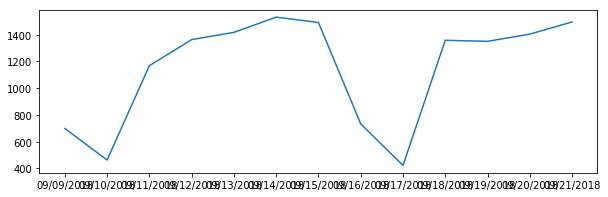

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))
plt.plot(dates_list, counts_list)

### Challenge 5

So far we've been operating on a single turnstile level, let's combine turnstiles in the same ControlArea/Unit/Station combo. There are some ControlArea/Unit/Station groups that have a single turnstile, but most have multiple turnstilea-- same value for the C/A, UNIT and STATION columns, different values for the SCP column.

We want to combine the numbers together -- for each ControlArea/UNIT/STATION combo, for each day, add the counts from each turnstile belonging to that combo.